# Avaliação de aprovação de cartão de crédito

O objetivo do projeto é criar um modelo de aprendizado de máquina capaz de prever se um pedido de cartão de crédito deve ser aprovado ou não com base em várias características do solicitante. 

As características usadas para prever a aprovação do cartão de crédito incluem informações pessoais e profissionais dos aplicantes.

Dataset disponível [aqui](https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [2]:
application = pd.read_csv("datasets/application_record.csv")
records = pd.read_csv("datasets/credit_record.csv")

# 1. Análise exploratória de dados

<h3> Informações sobre as variáveis em "Application" </h3>

`CODE_GENDER` → Gênero
<br>
`FLAG_OWN_CAR` → Possui veículo próprio
<br>
`FLAG_OWN_REALTY` → Possui imóvel próprio
<br>
`CNT_CHILDREN` → Quantide de filhos
<br>
`AMT_INCOME_TOTAL` → Renda total
<br>
`NAME_INCOME_TYPE` → Origem da renda
<br>
`NAME_EDUCATION_TYPE` → Nível de educação
<br>
`NAME_FAMILY_STATUS` → Estado civil
<br>
`NAME_HOUSING_TYPE` → Tipo de moradia
<br>
`DAYS_BIRTH` → Contagem regressiva de dias até a data de nascimento (-1 corresponde a ontem)
<br>
`DAYS_EMPLOYED` → Contagem regressiva de dias até a data de nascimento. Se positivo, significa que a pessoa está desempregada pelos dias correspondentes
<br>
`FLAG_MOBIL` → Possui telefone celular
<br>
`FLAG_WORK_PHONE` → Possui telefone celular corporativo
<br>
`FLAG_PHONE` → Possui telefone residencial
<br>
`FLAG_EMAIL` → Possui e-mail
<br>
`OCCUPATION_TYPE` → Profissão

In [3]:
application.head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
5,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
6,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
7,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0
8,5008813,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0
9,5008814,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0


In [4]:
application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

<h3> Informações sobre as variáveis em "Records" </h3>

Cada ID possui uma entrada para cada mês desde sua aplicação, contendo na coluna 'STATUS' uma flag que corresponde a um determinado <br>
intervalo de dias que se passaram desde a contratação do crédito sem que houvesse pagamento

`MONTHS_BALANCE` → Contagem regressiva de meses desde a aplicação (-1 corresponde ao mês passado)
<br> 
`STATUS` → <br>
    <li> 0: 1-29 dias <br>
    <li> 1: 30-59 dias <br>
    <li> 2: 60-89 dias <br>
    <li> 3: 90-119 dias <br>
    <li> 4: 120-149 dias <br>
    <li> 5: Mais de 150 dias de inadimplência <br>
    <li> C: Pago naquele mês <br>
    <li> X: Sem debitos naquele mês <br>

In [5]:
records.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [6]:
records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


# 2. Transformação dos dados

In [7]:
application['ID'].nunique() # Total de IDs únicos em "Applications" difere do total de linhas, ou seja, há dados duplicados

438510

In [8]:
application = application.drop_duplicates('ID', keep='last') # Eliminando dados duplicados, mantendo sempre o dado que aparece por último

<Axes: >

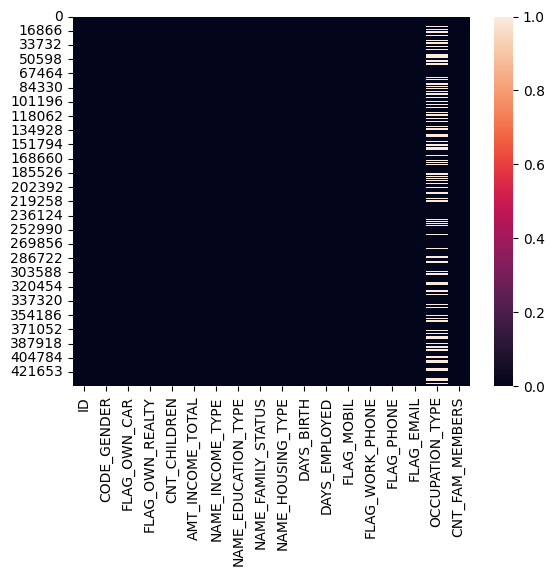

In [9]:
sns.heatmap(application.isnull()) # Verificando colunas com ocorrências de dados nulos em "Applications"

<Axes: >

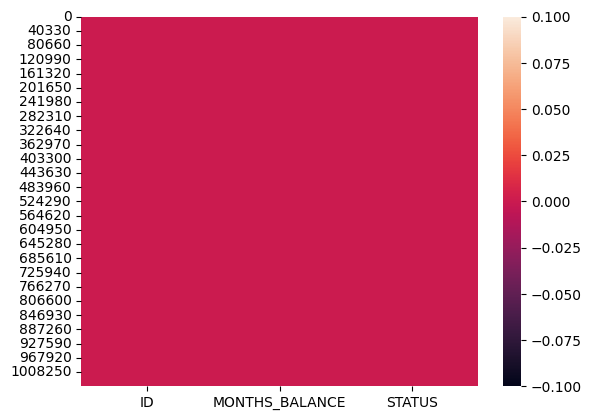

In [10]:
sns.heatmap(records.isnull()) # Verificando colunas com ocorrências de dados nulos em "Records"

In [11]:
application.drop(['OCCUPATION_TYPE'], axis=1, inplace=True) # Eliminando coluna 'OCCUPATION_TYPE' que possui entradas com valores nulos

In [12]:
le = LabelEncoder()
for x in application:
    if application[x].dtypes=='object':
        application[x] = le.fit_transform(application[x])
        
# Transformando dados não numéricos em numéricos

<Axes: xlabel='ID', ylabel='CNT_FAM_MEMBERS'>

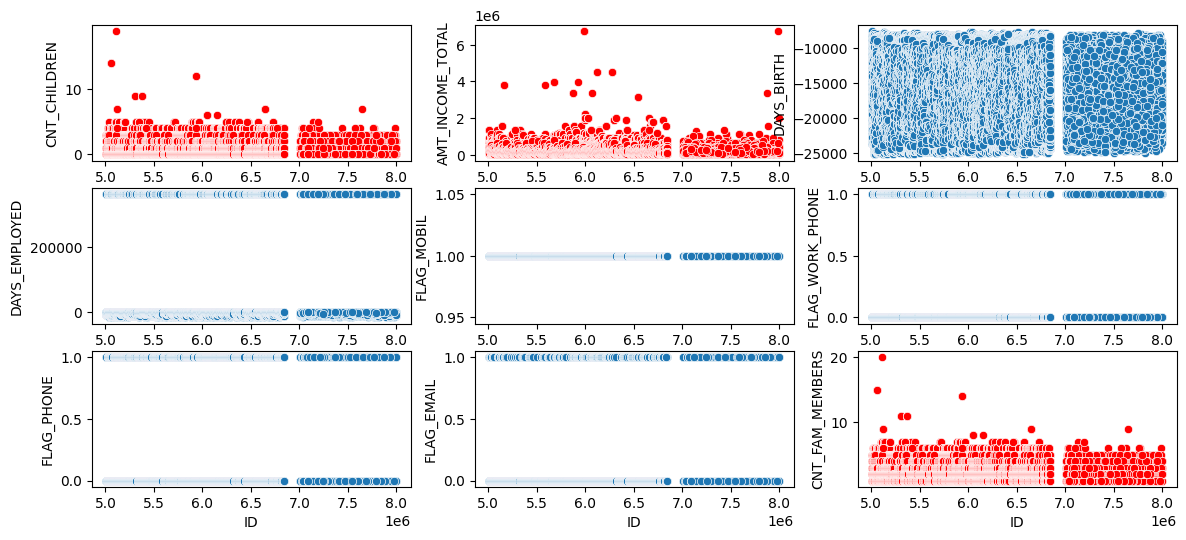

In [13]:
fig, ax= plt.subplots(nrows= 3, ncols = 3, figsize= (14,6))

sns.scatterplot(x='ID', y='CNT_CHILDREN', data=application, ax=ax[0][0], color= 'red')
sns.scatterplot(x='ID', y='AMT_INCOME_TOTAL', data=application, ax=ax[0][1], color='red')
sns.scatterplot(x='ID', y='DAYS_BIRTH', data=application, ax=ax[0][2])
sns.scatterplot(x='ID', y='DAYS_EMPLOYED', data=application, ax=ax[1][0])
sns.scatterplot(x='ID', y='FLAG_MOBIL', data=application, ax=ax[1][1])
sns.scatterplot(x='ID', y='FLAG_WORK_PHONE', data=application, ax=ax[1][2])
sns.scatterplot(x='ID', y='FLAG_PHONE', data=application, ax=ax[2][0])
sns.scatterplot(x='ID', y='FLAG_EMAIL', data=application, ax=ax[2][1])
sns.scatterplot(x='ID', y='CNT_FAM_MEMBERS', data=application, ax=ax[2][2], color= 'red')

# Verificando outliers (em vermelho as colunas com ocorrências de outliers)

In [14]:
out_max = application['CNT_CHILDREN'].quantile(0.999)
out_min = application['CNT_CHILDREN'].quantile(0.001)
application = application[(application['CNT_CHILDREN']>out_min) & (application['CNT_CHILDREN']<out_max)]

# Eliminando outliers em "CNT_CHILDREN"

In [15]:
out_max = application['AMT_INCOME_TOTAL'].quantile(0.999)
out_min = application['AMT_INCOME_TOTAL'].quantile(0.001)
application = application[(application['AMT_INCOME_TOTAL']>out_min) & (application['AMT_INCOME_TOTAL']<out_max)]

# Eliminando outliers em "AMT_INCOME_TOTAL"

In [16]:
out_max = application['CNT_FAM_MEMBERS'].quantile(0.999)
out_min = application['CNT_FAM_MEMBERS'].quantile(0.001)
application = application[(application['CNT_FAM_MEMBERS']>out_min) & (application['CNT_CHILDREN']<out_max)]

# Eliminando outliers em "CNT_FAM_MEMBERS"

<Axes: xlabel='ID', ylabel='CNT_FAM_MEMBERS'>

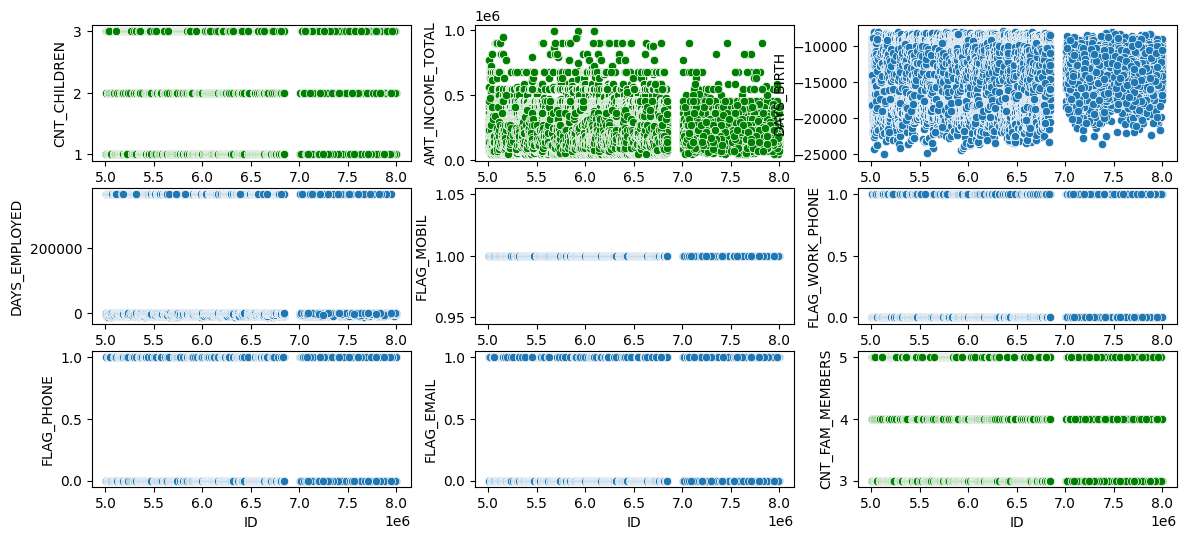

In [17]:
fig, ax= plt.subplots(nrows= 3, ncols = 3, figsize= (14,6))

sns.scatterplot(x='ID', y='CNT_CHILDREN', data=application, ax=ax[0][0], color= 'green')
sns.scatterplot(x='ID', y='AMT_INCOME_TOTAL', data=application, ax=ax[0][1], color='green')
sns.scatterplot(x='ID', y='DAYS_BIRTH', data=application, ax=ax[0][2])
sns.scatterplot(x='ID', y='DAYS_EMPLOYED', data=application, ax=ax[1][0])
sns.scatterplot(x='ID', y='FLAG_MOBIL', data=application, ax=ax[1][1])
sns.scatterplot(x='ID', y='FLAG_WORK_PHONE', data=application, ax=ax[1][2])
sns.scatterplot(x='ID', y='FLAG_PHONE', data=application, ax=ax[2][0])
sns.scatterplot(x='ID', y='FLAG_EMAIL', data=application, ax=ax[2][1])
sns.scatterplot(x='ID', y='CNT_FAM_MEMBERS', data=application, ax=ax[2][2], color= 'green')

# Dados após eliminação dos outliers

In [18]:
records['STATUS'].replace({'C': 0, 'X' : 0}, inplace=True)
records['STATUS'] = records['STATUS'].astype('int')
records['STATUS'] = records['STATUS'].apply(lambda x:1 if x >= 2 else 0)
records = records.groupby('ID').agg(max).reset_index()

# Substituindo valores "C" e "X" da coluna "STATUS" por 0, pois possuem a mesma equivalência (estão em dia)
# Aplicando regra de corte para valores com "STATUS" maior que 2, ou seja, mais de 60 dias em atraso
# Mantendo apenas um registro por ID, constando um status que apresenta o máximo de dias que este ID esteve inadimplente

In [19]:
application.head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
27,5008836,1,1,1,3,270000.0,4,4,1,1,-12689,-1163,1,0,0,0,5.0
28,5008837,1,1,1,3,270000.0,4,4,1,1,-12689,-1163,1,0,0,0,5.0
29,5008838,1,0,1,1,405000.0,0,1,1,1,-11842,-2016,1,0,0,0,3.0
30,5008839,1,0,1,1,405000.0,0,1,1,1,-11842,-2016,1,0,0,0,3.0
31,5008840,1,0,1,1,405000.0,0,1,1,1,-11842,-2016,1,0,0,0,3.0
32,5008841,1,0,1,1,405000.0,0,1,1,1,-11842,-2016,1,0,0,0,3.0
33,5008842,1,0,1,1,405000.0,0,1,1,1,-11842,-2016,1,0,0,0,3.0
34,5008843,1,0,1,1,405000.0,0,1,1,1,-11842,-2016,1,0,0,0,3.0
46,5008854,0,1,1,2,135000.0,4,4,1,1,-15761,-3173,1,0,0,0,4.0
47,5008855,0,1,1,2,135000.0,4,4,1,1,-15761,-3173,1,0,0,0,4.0


In [20]:
records.head(10)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,0
1,5001712,0,0
2,5001713,0,0
3,5001714,0,0
4,5001715,0,0
5,5001717,0,0
6,5001718,0,0
7,5001719,0,0
8,5001720,0,0
9,5001723,0,0


In [21]:
len(records) # Total de linhas em "Records"

45985

In [22]:
len(application) # Total de linhas em "Application"

119208

In [23]:
df = application.join(records.set_index('ID'), on='ID', how='inner')
df.drop(['MONTHS_BALANCE'], axis=1, inplace=True)

# Juntando "Application" com "Records" em um novo dataframe

In [24]:
df.head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,STATUS
27,5008836,1,1,1,3,270000.0,4,4,1,1,-12689,-1163,1,0,0,0,5.0,0
28,5008837,1,1,1,3,270000.0,4,4,1,1,-12689,-1163,1,0,0,0,5.0,0
29,5008838,1,0,1,1,405000.0,0,1,1,1,-11842,-2016,1,0,0,0,3.0,0
30,5008839,1,0,1,1,405000.0,0,1,1,1,-11842,-2016,1,0,0,0,3.0,0
31,5008840,1,0,1,1,405000.0,0,1,1,1,-11842,-2016,1,0,0,0,3.0,0
32,5008841,1,0,1,1,405000.0,0,1,1,1,-11842,-2016,1,0,0,0,3.0,0
33,5008842,1,0,1,1,405000.0,0,1,1,1,-11842,-2016,1,0,0,0,3.0,0
34,5008843,1,0,1,1,405000.0,0,1,1,1,-11842,-2016,1,0,0,0,3.0,0
46,5008854,0,1,1,2,135000.0,4,4,1,1,-15761,-3173,1,0,0,0,4.0,0
47,5008855,0,1,1,2,135000.0,4,4,1,1,-15761,-3173,1,0,0,0,4.0,0


In [25]:
len(df)  # Total de linhas do novo dataframe

9903

In [26]:
df['STATUS'].value_counts(normalize=True) # Verificando balanceamento dos dados

0    0.98354
1    0.01646
Name: STATUS, dtype: float64

# 3. Desenvolvendo o modelo

Através da exploração dos dados entendeu-se que se trata de um problema de classificação binária, onde nossa variável alvo apresenta 0 ou 1 para definir aplicações que vieram
<br> a se tornar problema no futuro <br><br>
Entendeu-se e definiu-se que o modelo deve se basear nas aplicações que ficaram, pelo menos uma vez, inadimplentes por mais de 60 dias como fator para reprovar a análise de crédito.

In [27]:
x = df.iloc[:,1:-1] # Colunas exceto as de classificação
y = df.iloc[:,-1] # Colunas de classificação

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3) # Dividindo os dados entre teste e treino

In [29]:
mms = MinMaxScaler()
x_scaled = pd.DataFrame(mms.fit_transform(x_train), columns=x_train.columns)
x_test_scaled = pd.DataFrame(mms.transform(x_test), columns=x_test.columns)

# Escalando dados para um resultado mais acurado

In [30]:
oversample = SMOTE()
x_balanced, y_balanced = oversample.fit_resample(x_scaled, y_train)
x_test_balanced, y_test_balanced = oversample.fit_resample(x_test_scaled, y_test)

# Lidando com o problema de superamostragem

In [31]:
classifiers = {
    "LogisticRegression" : LogisticRegression(),
    "KNeighbors" : KNeighborsClassifier(),
    "SVC" : SVC(),
    "DecisionTree" : DecisionTreeClassifier(),
    "RandomForest" : RandomForestClassifier(),
    "XGBoost" : XGBClassifier()
}

# Definindo modelos a serem testados

In [32]:
train_scores = []
test_scores = []

for key, classifier in classifiers.items():
    classifier.fit(x_balanced, y_balanced)
    train_score = classifier.score(x_balanced, y_balanced)
    train_scores.append(train_score)
    test_score = classifier.score(x_test_balanced, y_test_balanced)
    test_scores.append(test_score)

print(train_scores)
print(test_scores)

# Executando os modelos e verificando acurácia

[0.6456410256410257, 0.9796336996336996, 0.9245421245421246, 0.9951648351648351, 0.9951648351648351, 0.9945787545787546]
[0.5704974271012007, 0.7271012006861064, 0.7555746140651801, 0.8176672384219554, 0.8192109777015437, 0.9499142367066895]


In [33]:
xgb = XGBClassifier()
model = xgb.fit(x_balanced, y_balanced)
prediction = xgb.predict(x_test_balanced)

# Escolhendo o melhor modelo = XGBoost

In [34]:
print(classification_report(y_test_balanced, prediction))

# Resultado do modelo

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      2915
           1       0.99      0.91      0.95      2915

    accuracy                           0.95      5830
   macro avg       0.95      0.95      0.95      5830
weighted avg       0.95      0.95      0.95      5830



# Conclusão

Após testes, concluiu-se que o modelo XGBoost obteve melhor acurácia.